## Original Description
> Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.
>
> The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.
>
> While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
>
> To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.
>
> Help save them and change history!

### Features
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.

### Labels
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [170]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [171]:
%matplotlib inline

In [172]:
redo_graphs = 0

In [173]:
def transform_df(X):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  X = X.drop(['Age', "Total"],axis=1)
  X['age'] = X['age'].astype('str') 
  X['total'] = X['total'].astype('str') 
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [174]:
from sklearn.pipeline import make_pipeline
import pandas as pd

class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

pandas_preprocessing = make_pipeline(
    DataframeFunctionTransformer(transform_df)
)

In [175]:
df = pd.read_csv('data_FAA/train.csv')
df, y = pandas_preprocessing.fit_transform(df)
df.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,Group_id,Surname,Deck,CabinNumber,CabinSide,age,total
0,Europa,False,TRAPPIST-1e,False,0.00,0.00,0.00,0.00,0.00,0001,01,Ofracculy,B,0.00,P,"(30, 40]","(-35.987, 3598.7]"
1,Earth,False,TRAPPIST-1e,False,109.00,9.00,25.00,549.00,44.00,0002,01,Vines,F,0.00,S,"(20, 30]","(-35.987, 3598.7]"
2,Europa,False,TRAPPIST-1e,True,43.00,3576.00,0.00,6715.00,49.00,0003,01,Susent,A,0.00,S,"(50, 60]","(7197.4, 10796.1]"
3,Europa,False,TRAPPIST-1e,False,0.00,1283.00,371.00,3329.00,193.00,0003,02,Susent,A,0.00,S,"(30, 40]","(3598.7, 7197.4]"
4,Earth,False,TRAPPIST-1e,False,303.00,70.00,151.00,565.00,2.00,0004,01,Santantines,F,1.00,S,"(10, 20]","(-35.987, 3598.7]"


In [176]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
    )

boo_pipeline = make_pipeline(
    
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    ('passthrough',make_column_selector(dtype_include=bool)),
)

In [177]:
df_prepared = preprocessing.fit_transform(df)

In [178]:
df_prepared_fr = pd.DataFrame(
    df_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)
df_prepared_fr.head(1)

,pipeline-1__RoomService,pipeline-1__FoodCourt,pipeline-1__ShoppingMall,pipeline-1__Spa,pipeline-1__VRDeck,pipeline-1__CabinNumber,pipeline-2__HomePlanet,pipeline-2__CryoSleep,pipeline-2__Destination,pipeline-2__VIP,pipeline-2__Group,pipeline-2__Group_id,pipeline-2__Surname,pipeline-2__Deck,pipeline-2__CabinSide,pipeline-2__age,pipeline-2__total
0,-0.33,-0.28,-0.28,-0.27,-0.26,-1.18,1.00,0.00,2.00,0.00,0.00,0.00,1431.00,1.00,0.00,3.00,0.00


In [179]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared_fr, y, test_size = 0.2, random_state = 100)

In [180]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)

100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


In [181]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.82,0.82,0.82,0.82,1.81
NuSVC,0.81,0.81,0.81,0.81,2.25
ExtraTreesClassifier,0.81,0.81,0.81,0.81,0.56
RandomForestClassifier,0.80,0.80,0.80,0.80,0.90
LGBMClassifier,0.80,0.80,0.80,0.80,0.21
XGBClassifier,0.80,0.80,0.80,0.80,0.32
LinearSVC,0.79,0.79,0.79,0.79,0.48
CalibratedClassifierCV,0.79,0.79,0.79,0.79,1.70
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.38


In [182]:
import plotly.express as px

line = px.line(data_frame= models ,y =["Accuracy"] , markers = True, width=600, height=600)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend = False,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [183]:
X_train.head()

,pipeline-1__RoomService,pipeline-1__FoodCourt,pipeline-1__ShoppingMall,pipeline-1__Spa,pipeline-1__VRDeck,pipeline-1__CabinNumber,pipeline-2__HomePlanet,pipeline-2__CryoSleep,pipeline-2__Destination,pipeline-2__VIP,pipeline-2__Group,pipeline-2__Group_id,pipeline-2__Surname,pipeline-2__Deck,pipeline-2__CabinSide,pipeline-2__age,pipeline-2__total
8024,-0.33,-0.28,-0.28,-0.27,-0.26,-0.07,2.00,1.00,2.00,0.00,5756.00,0.00,2191.00,4.00,1.00,5.00,0.00
6142,-0.20,-0.28,1.05,-0.27,-0.26,0.90,0.00,0.00,2.00,0.00,4379.00,0.00,278.00,6.00,1.00,2.00,0.00
3707,1.51,-0.28,-0.28,-0.27,-0.26,0.31,2.00,0.00,2.00,0.00,2666.00,0.00,1547.00,5.00,1.00,5.00,0.00
2839,-0.33,-0.28,-0.28,0.13,-0.04,-0.80,0.00,0.00,2.00,0.00,2055.00,2.00,547.00,4.00,0.00,1.00,0.00
3688,-0.33,0.47,-0.28,-0.27,0.13,-0.71,0.00,0.00,1.00,0.00,2650.00,1.00,894.00,4.00,0.00,5.00,0.00


In [184]:
import joblib
with open('data_FAA/data.pkl', 'wb') as f:
    joblib.dump([X_train, y_train, X_test, y_test], f)

ValueError: Could not interpret input 'boo_CryoSleep'

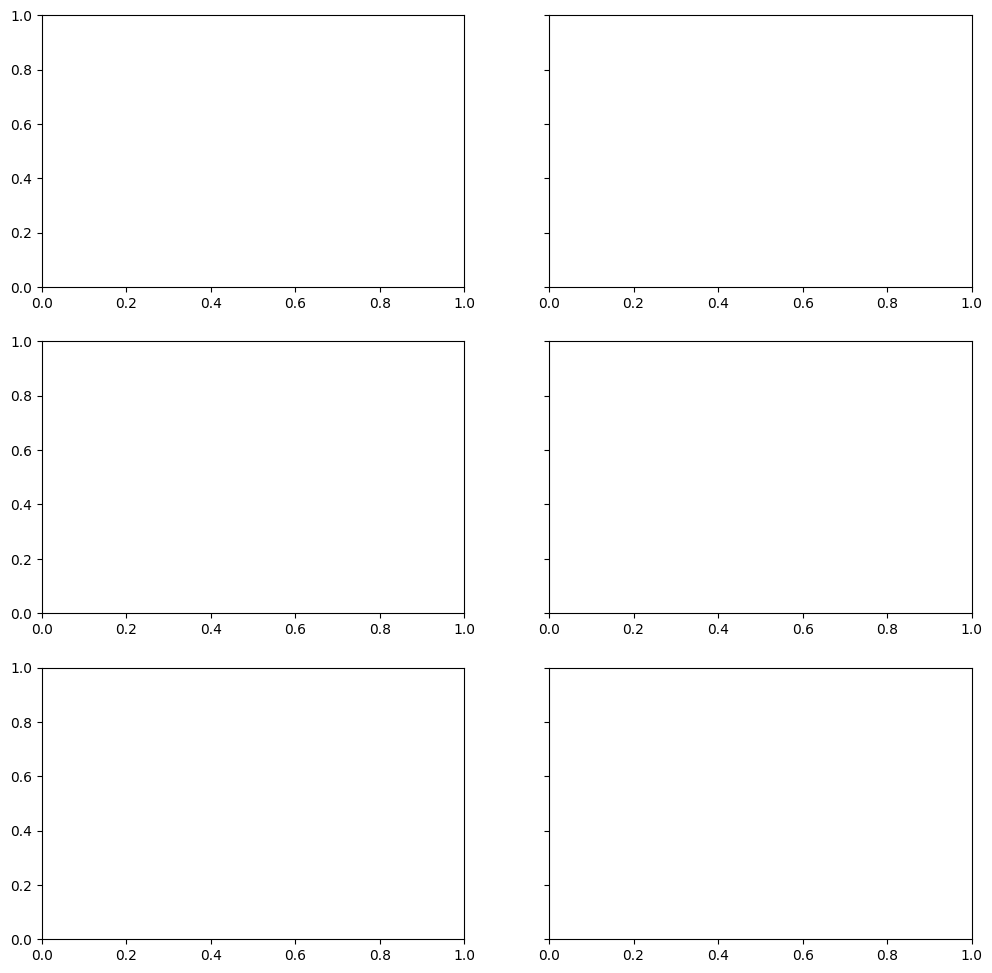

In [185]:
# Tentar visualizar a dependência de Transported com as variáveis binárias (ou com poucos elementos)
# Fazer o mesmo com as novas features (p.e. Age depois de agrupar)
#fig, axes = plt.subplots(3, 2, figsize=(12,12),sharey=True)
#
#k = 0
#for col in cat_columns:
#    if col not in ["cat_Group", "cat_Surname", "cat_FirstName", "cat_HomePlanet"]:
#        sns.countplot(ax=axes[k%3, k//3],hue='Transported',x=col,data=df_train)
#        k += 1
#plt.savefig("Imagens_FAA/4graphs.png")
fig, axes = plt.subplots(3, 2, figsize=(12,12),sharey=True)
sns.countplot(ax=axes[0,0],hue='Transported',x='boo_CryoSleep',data=df_train)
sns.countplot(ax=axes[0,1],hue='Transported',x='boo_VIP',data=df_train)
sns.countplot(ax=axes[1,0],hue='Transported',x='cat_HomePlanet',data=df_train)
sns.countplot(ax=axes[1,1],hue='Transported',x='cat_Destination',data=df_train)
sns.countplot(ax=axes[2,0],hue='Transported',x='cat_Deck',data=df_train)
sns.countplot(ax=axes[2,1],hue='Transported',x='cat_CabinSide',data=df_train)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,12),sharey=True)
sns.countplot(ax=axes[0],hue='Transported',x='cat_Age',data=df_train)
sns.countplot(ax=axes[1],hue='Transported',x='cat_total',data=df_train)

In [ ]:
fig = px.histogram(data_frame = df_train, x=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],marginal="box",nbins=100)
fig.update_layout(title = "Money spent on the spaceship" , title_x = 0.5)
fig.show()

In [ ]:
# #  Tentar visualizar a dependência de Transported com as restantes variáveis através de boxplots
# sns.boxplot(x='Transported',y='Age',data=df_train)
# plt.savefig("Imagens_FAA/Age.png")

In [ ]:
# # Não dá para visualizar muito bem porque a maior parte dos valores é dada como outlier
if redo_graphs:
    sns.boxplot(x='Transported',y='VRDeck',data=df_train)
    plt.savefig("Imagens_FAA/Boxplot_VRDeck.png")

In [ ]:
if redo_graphs:
    num_columns.append("Transported")
    sns.pairplot(df_train[num_columns], kind="scatter", hue="Transported")
    plt.savefig("Imagens_FAA/Full_pairplot_cont.png")
    plt.show()

In [ ]:
if redo_graphs:
    sns.pairplot(df_train, kind="scatter", hue="Transported")
    plt.show()
    plt.savefig("Imagens_FAA/Full_pairplot.png")

In [ ]:
if redo_graphs:
    corr = df_train.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.4, cbar_kws={"shrink": .5})
    # Not sure of the reason why but the below command saves it some with border
    plt.savefig("Imagens_FAA/Correlation.png")

In [ ]:
#define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#create chart in each subplot
sns.countplot(df_train, x="cat_CryoSleep", hue="Transported", ax=axes[1])
sns.countplot(df_train, x="SpendCategory", hue="Transported", ax=axes[0])

In [ ]:
#define dimensions of subplots (rows, columns)
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#create chart in each subplot
sns.scatterplot(df_train, x="FoodCourt", y="Spa", hue="Transported")